# Make some statistic over imbalance price

The data used for the different plots are extracted from [here](https://transparency.entsoe.eu/balancing/r2/imbalance/show). A copy can be found in the folder [EntsoeData](../DataFiles/EntsoeData/)

In [1]:
# Import Modules to use 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'


---
----
# 2019 Data

## Extract DataSet

In [2]:
folder = '../DataFiles/EntsoeData/' # DataSet Locationn
year = '2019'
file_name = folder+'Imbalance_'+year+'.csv'

week_days = ['Monday', 'Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']

Hour_str = ['', '00:00-00:30', '01:00-01:30', '02:00-02:30', '03:00-03:30','04:00-04:30', '05:00-05:30', '06:00-06:30',
            '07:00-07:30', '08:00-08:30', '09:00-09:30', '10:00-10:30','11:00-11:30', '12:00-12:30', '13:00-13:30',
            '14:00-14:30', '15:00-15:30', '16:00-16:30', '17:00-17:30','18:00-18:30', '19:00-19:30', '20:00-20:30',
            '21:00-21:30', '22:00-22:30', '23:00-23:30', ]

title_list = ['Imbalance+ [EUR/MWh]', 'Imbalance- [EUR/MWh]', 'Total Imbalance [MWh]']

startt = year+'-01-01'      # First index
endd = year+'-12-31 23:30'  # last index

per_30mn = pd.date_range(startt, endd, freq='30T',)     # Create a date range at a freq of 30mn 
per_1day = pd.date_range(startt, endd, freq='D',)       # Create a date range at a freq of 1 day 

per_1month =  pd.date_range(startt, endd, freq='M',)    # Create date range to

imbalance_data = pd.read_csv(file_name,index_col='ISP (UTC)')
imbalance_data.index = per_30mn

## Basic statistic on the dataset

In [3]:
imbalance_data.describe()

,Imbalance+ [EUR/MWh],Imbalance- [EUR/MWh],Total Imbalance [MWh]
count,17520.000000,17520.000000,17517.000000
mean,37.539244,41.503642,361.055146
std,20.068056,22.133153,290.116815
min,-81.360000,-73.620000,0.000000
25%,27.020000,29.860000,138.000000
50%,35.870000,39.650000,294.000000
75%,46.490000,51.390000,513.000000
max,981.760000,1085.100000,2364.000000


## Extract Month Data
Each month consists of 48*nb_days data points

In [4]:
month_imb_pos, month_imb_neg ,month_imb_tot = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

for elm in per_1month.month_name():
    
    var_int = imbalance_data[per_30mn.month_name() == elm]['Imbalance+ [EUR/MWh]'].values # Positive imbalance (Selling) 
    nan_to_add = np.nan*np.zeros((1488-len(var_int))) # add NaN so that the data across all the months has the same 
                                                      # maximal length of 1488 = 31*48 (31 Days and 48 period of 30mn)
    month_imb_pos[elm] = np.concatenate((var_int,nan_to_add))
    
    var_int = imbalance_data[per_30mn.month_name() == elm]['Imbalance- [EUR/MWh]'].values # Negative imbalance (buying)
    month_imb_neg[elm] = np.concatenate((var_int,nan_to_add))
     
    var_int = imbalance_data[per_30mn.month_name() == elm]['Total Imbalance [MWh]'].values # Total imbalance
    month_imb_tot[elm] = np.concatenate((var_int,nan_to_add))

####  Plot data

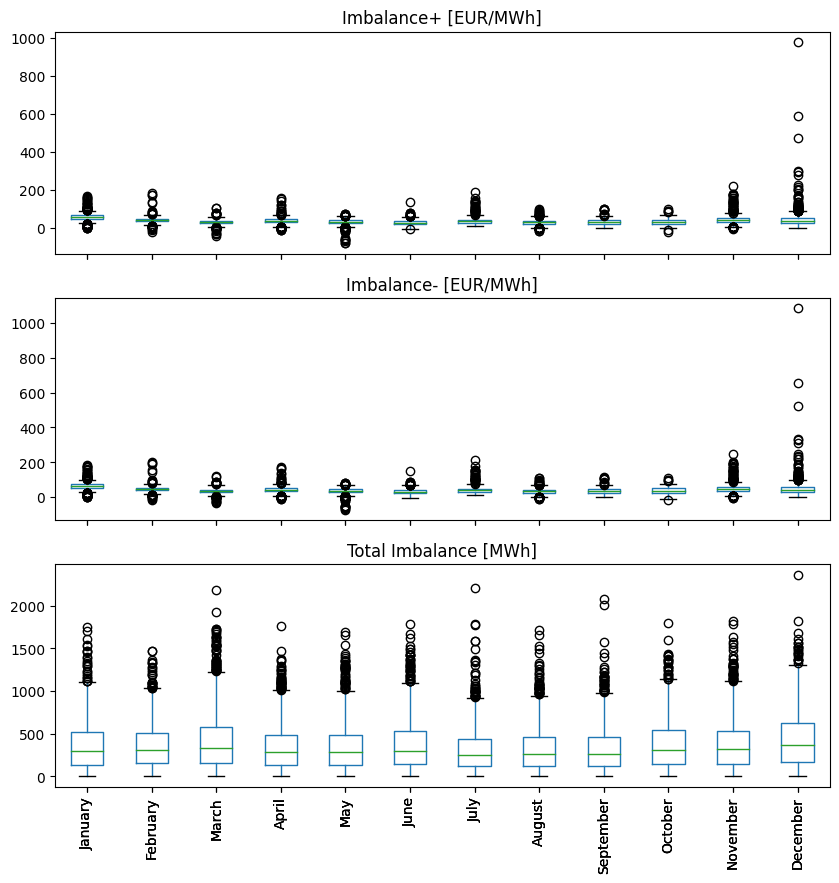

In [5]:
# Plotting 
fig, axx = plt.subplots(3,1, figsize=(10,10),sharex=True, dpi=100)
al = month_imb_pos.boxplot(ax=axx[0],)
month_imb_neg.boxplot(ax=axx[1],)
month_imb_tot.boxplot(ax=axx[2],);

for j in range(0,3): 
    axx[j].set(title=title_list[j],)
    axx[j].grid(False)
    
plt.xticks(rotation=90);

## Extract daily mean over each month

Here we consider the daily mean of the imbalance price data. A monthly aggregation is produced hereafter. Every month, therefore, consists of 28 (February), 30 or 31 data points.

In [6]:
# Create Dataframe to store the data 
month_imb_pos, month_imb_neg ,month_imb_tot = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

cur_nb_days = 1 # Index of the current day

for elm in per_1month.month_name():
    
    imb_pos_list, imb_neg_list ,imb_tot_list = [], [], [] # List to store data
    
    tot_day_month = per_30mn[per_30mn.month_name() == elm].days_in_month[1] # Extract the total number of days in the considered month
    
    for jour in range(cur_nb_days, cur_nb_days+tot_day_month): # For each day in the month compute mean and store it
        imb_pos,imb_neg,imb_tot = imbalance_data[per_30mn.dayofyear == jour].mean()
        imb_pos_list.append(imb_pos), 
        imb_neg_list.append(imb_neg),
        imb_tot_list.append(imb_tot)
    
    nan_to_add = np.nan*np.zeros((31-len(imb_pos_list))) # 31 upper bound of number of days in a month
    month_imb_pos[elm] = np.concatenate((np.array(imb_pos_list),nan_to_add)) # Positive imbalance (Selling)  
    month_imb_neg[elm] = np.concatenate((np.array(imb_neg_list),nan_to_add)) # Negative imbalance (buying)
    month_imb_tot[elm] = np.concatenate((np.array(imb_tot_list),nan_to_add)) # total imbalance
    
    cur_nb_days = cur_nb_days + tot_day_month

####  Plot data

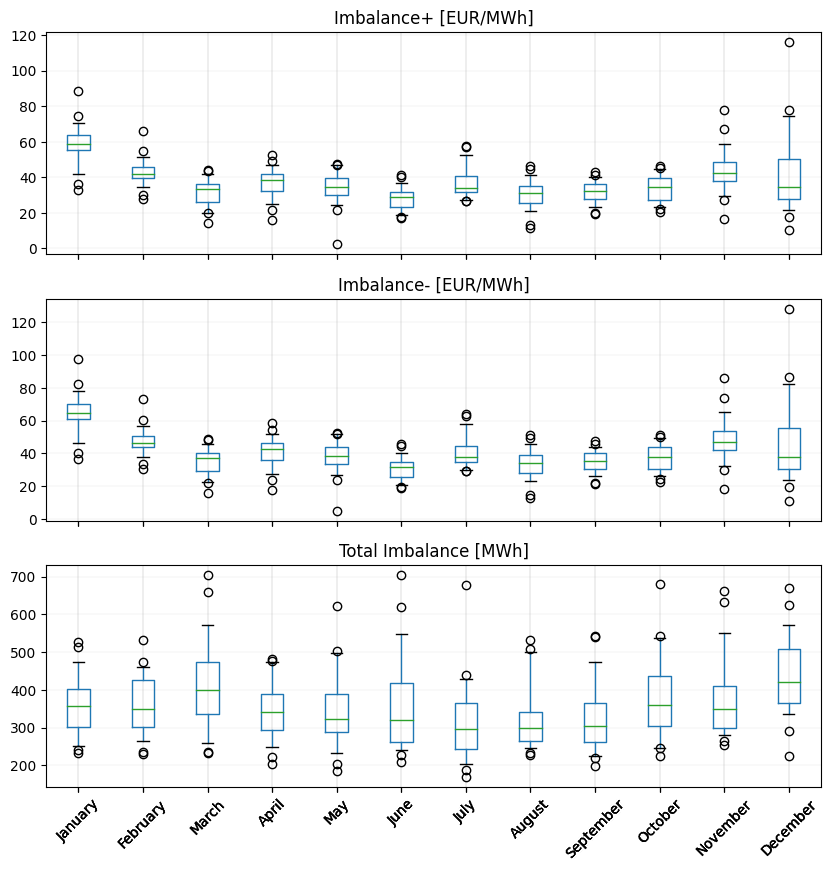

In [7]:
# Ploting 
fig, axx = plt.subplots(3,1, figsize=(10,10),sharex=True,dpi=100)

# rer1 = month_imb_pos.boxplot(ax=axx[0],whis=[5,95],widths=0.25, patch_artist=True,)
month_imb_pos.boxplot(ax=axx[0],whis=[5,95],widths=0.35,)
month_imb_neg.boxplot(ax=axx[1],whis=[5,95],widths=0.35)
month_imb_tot.boxplot(ax=axx[2],whis=[5,95],widths=0.35);


for j in range(0,3): 
    axx[j].set(title=title_list[j],)
    axx[j].grid(True,lw=0.1)
plt.xticks(rotation=45);

## Extract Weekdays data
Whole year data, each day consists of 48*52 data points

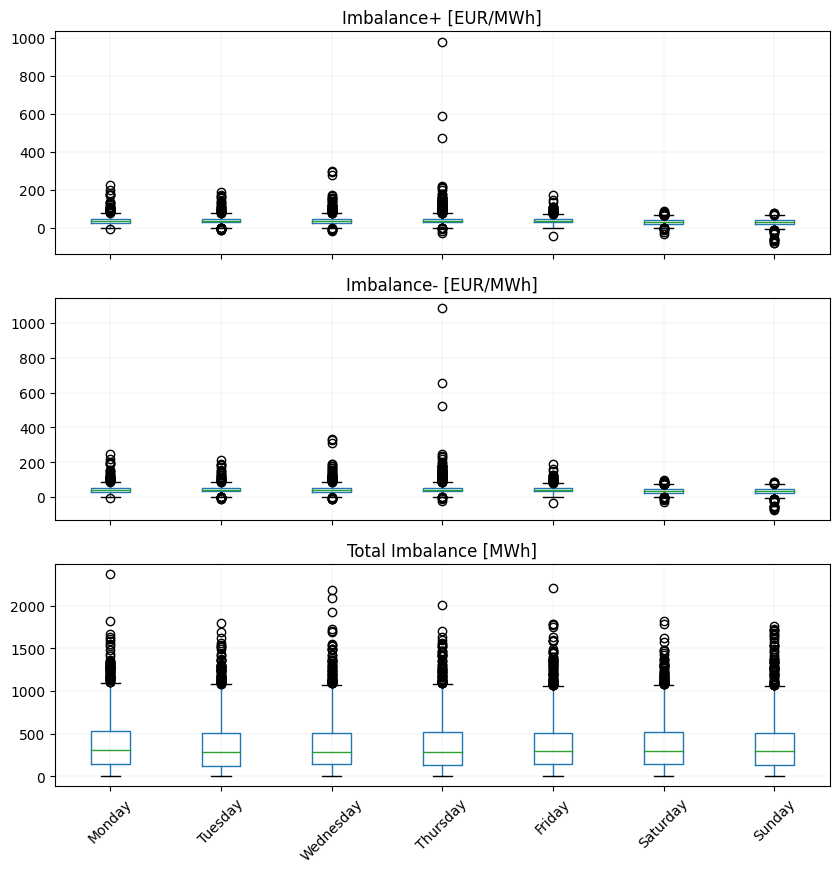

In [8]:
weekday_imb_pos, weekday_imb_neg ,weekday_imb_tot = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

max_length = 0
for day_number in range(1,8): # Extract the day with the highest frequency during the year
    max_length = np.maximum(max_length,len(imbalance_data[per_30mn.isocalendar()['day']==day_number]) )
    

for elm in range(1,8):
#     Positive imbalance (Selling)
    var_int = imbalance_data[per_30mn.isocalendar()['day']==elm]['Imbalance+ [EUR/MWh]'].values # Positive imbalance (Selling)
    nan_to_add = np.nan*np.zeros((max_length-len(var_int)))
    weekday_imb_pos[elm] = np.concatenate((var_int,nan_to_add))
    
    var_int = imbalance_data[per_30mn.isocalendar()['day']==elm]['Imbalance- [EUR/MWh]'].values # Negative imbalance (buying)
    weekday_imb_neg[elm] = np.concatenate((var_int,nan_to_add))
    
    var_int = imbalance_data[per_30mn.isocalendar()['day']==elm]['Total Imbalance [MWh]'].values # total imbalance
    weekday_imb_tot[elm] = np.concatenate((var_int,nan_to_add))
    
    
# Plotting 
fig, axx = plt.subplots(3,1, figsize=(10,10),sharex=True,dpi=100)

weekday_imb_pos.boxplot(ax=axx[0],widths=0.35,)
weekday_imb_neg.boxplot(ax=axx[1],widths=0.35)
weekday_imb_tot.boxplot(ax=axx[2],widths=0.35);

for j in range(0,3): 
    axx[j].set(title=title_list[j],)
    axx[j].grid(True,lw=0.1)
plt.xticks(ticks= range(1,8), labels=week_days, rotation=45);

## Extract particular months, using January and June as example
Each day consists of 48*nb_days(month) data points

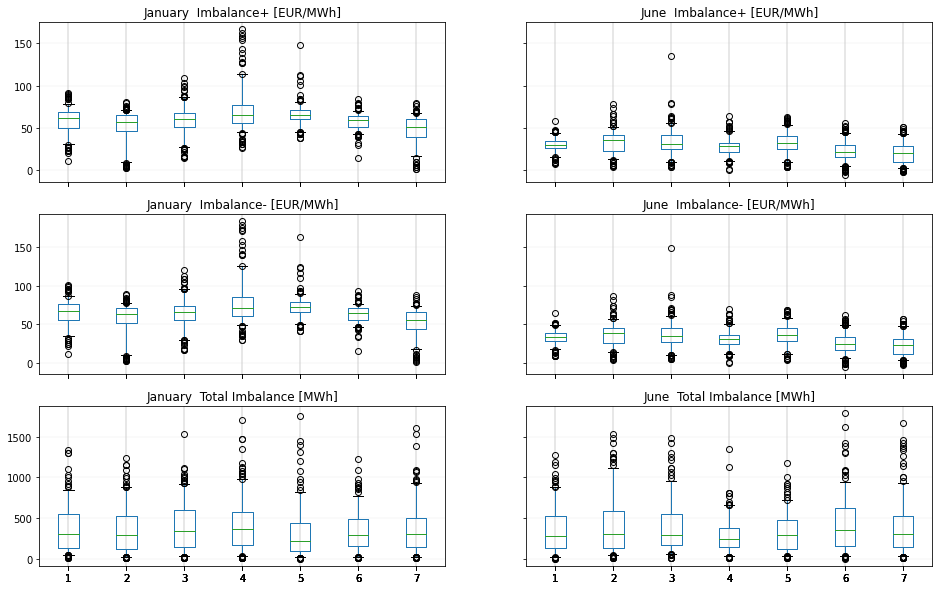

In [9]:
# Define a simple function        
def extract_month_data (month_name, first_day, last_day ):

    per_30mn_month = pd.date_range(first_day, last_day, freq='30T',)
    per_1day_month = pd.date_range(first_day, last_day, freq='D',)

    imbalance_data_month = imbalance_data[imbalance_data.index.month_name() == month_name]
    weekday_imb_pos, weekday_imb_neg ,weekday_imb_tot = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

    max_length = 0
    for day_number in range(1,8):
        max_length = np.maximum(max_length,len(imbalance_data_month[per_30mn_month.isocalendar()['day']==day_number]) )

    for elm in range(1,8):

        var_int = imbalance_data_month[per_30mn_month.isocalendar()['day']==elm]['Imbalance+ [EUR/MWh]'].values # Negative imbalance (Selling)
        nan_to_add = np.nan*np.zeros((max_length-len(var_int)))
        weekday_imb_pos[elm] = np.concatenate((var_int,nan_to_add))

        var_int = imbalance_data_month[per_30mn_month.isocalendar()['day']==elm]['Imbalance- [EUR/MWh]'].values # Negative imbalance (buying)
        weekday_imb_neg[elm] = np.concatenate((var_int,nan_to_add))

        var_int = imbalance_data_month[per_30mn_month.isocalendar()['day']==elm]['Total Imbalance [MWh]'].values # Total imbalance 
        nan_to_add = np.nan*np.zeros((max_length-len(var_int)))
        weekday_imb_tot[elm] = np.concatenate((var_int,nan_to_add))
        
    return weekday_imb_pos, weekday_imb_neg, weekday_imb_tot

# Use the created function------------------------------------------------------------------------------------------------------------------


month_name = ['January', 'June' ]  # Define name of selected months

startt_month = f'{year}-01-01'
endd_month = f'{year}-01-31 23:30' # IMPORTANT: Make sure the number and the last day of the selected month complies with reality
                                   # Eg: 01 for January which last day is 31 | 06 for June which last day is 30
startt_month2 = f'{year}-06-01'
endd_month2 = f'{year}-06-30 23:30'

# call function 
month0 = extract_month_data(month_name[0],startt_month, endd_month )
month1 = extract_month_data(month_name[1],startt_month2, endd_month2 )

# Ploting output of the function
fig, axx = plt.subplots(3,2, figsize=(16,10),sharex=True,sharey='row')

# rer1 = month_imb_pos.boxplot(ax=axx[0],whis=[5,95],widths=0.25, patch_artist=True,)
for elm in range(0, 3 ): 
    month0[elm].boxplot(ax=axx[elm,0],whis=[5,95],widths=0.35,)
    month1[elm].boxplot(ax=axx[elm,1],whis=[5,95],widths=0.35,)


for rows in range(0,3): 
    for colls in range(0,2):
        titre = month_name[colls] + '  ' + title_list[rows] 
        axx[rows, colls].set(title=titre,)
        axx[rows, colls].grid(True,lw=0.1)
# plt.xticks(ticks= range(1,8), labels=week_days, rotation=45);



##  Hour of day
Whole year data, each hour consists of 365 data points

In [10]:
hour_imb_pos_list, hour_imb_neg_list ,hour_imb_tot_list = [], [], [], 
total_days = len(per_1day) # Get the total numbers of day in the year 

for day_number in range(0,total_days-1):
    indexing = (per_1day[day_number]<= imbalance_data.index) & (imbalance_data.index < per_1day[day_number+1])

    hour_imb_pos_list.append( imbalance_data[indexing]['Imbalance+ [EUR/MWh]'].values )
    hour_imb_neg_list.append(imbalance_data[indexing]['Imbalance- [EUR/MWh]'].values)
    hour_imb_tot_list.append(imbalance_data[indexing]['Total Imbalance [MWh]'].values) 
    
    
hour_imb_pos = pd.DataFrame(data=hour_imb_pos_list, index=range(0,total_days-1))
hour_imb_neg = pd.DataFrame(data=hour_imb_neg_list, index=range(0,total_days-1))
hour_imb_tot = pd.DataFrame(data=hour_imb_tot_list, index=range(0,total_days-1))

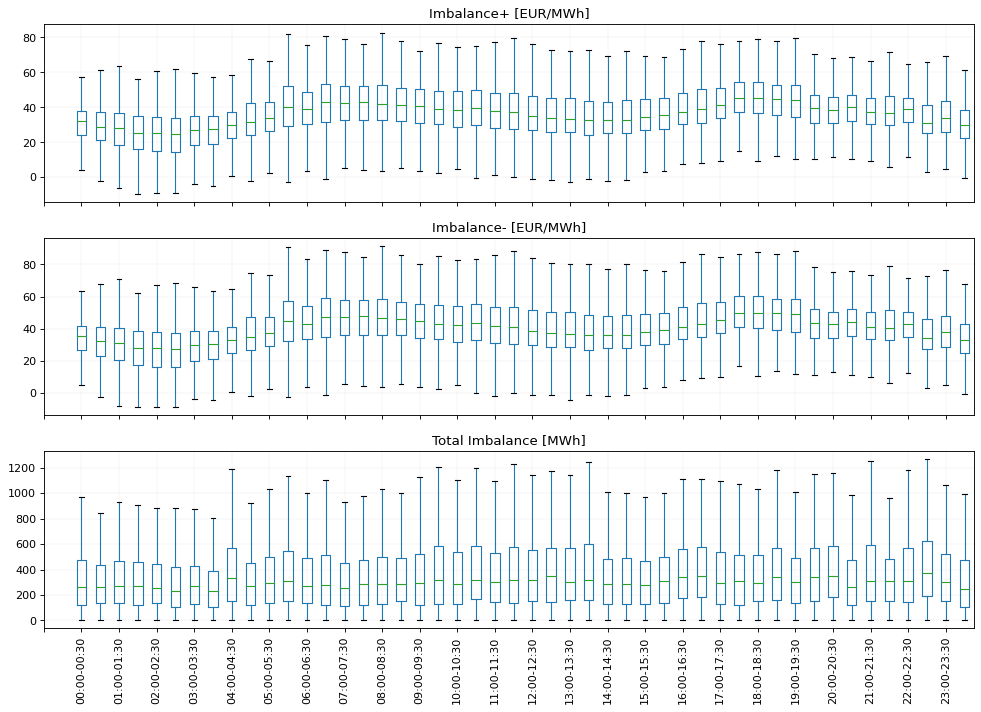

In [11]:
fig, axx = plt.subplots(3,1, figsize=(15,10),sharex=True,dpi=80)
hour_imb_pos.boxplot(ax=axx[0],sym='')
hour_imb_neg.boxplot(ax=axx[1],sym='')
hour_imb_tot.boxplot(ax=axx[2],sym='')
axx[0].set(xticks = range(-1,48,2), xticklabels=Hour_str);
axx[1].set(xticks = range(-1,48,2),);
axx[2].set(xticks = range(-1,48,2),);

for j in range(0,3): 
    axx[j].set(title=title_list[j],)
    axx[j].grid(True,lw=0.1)
plt.xticks(rotation=90,);

## January data
Each hour consists of 31 data points

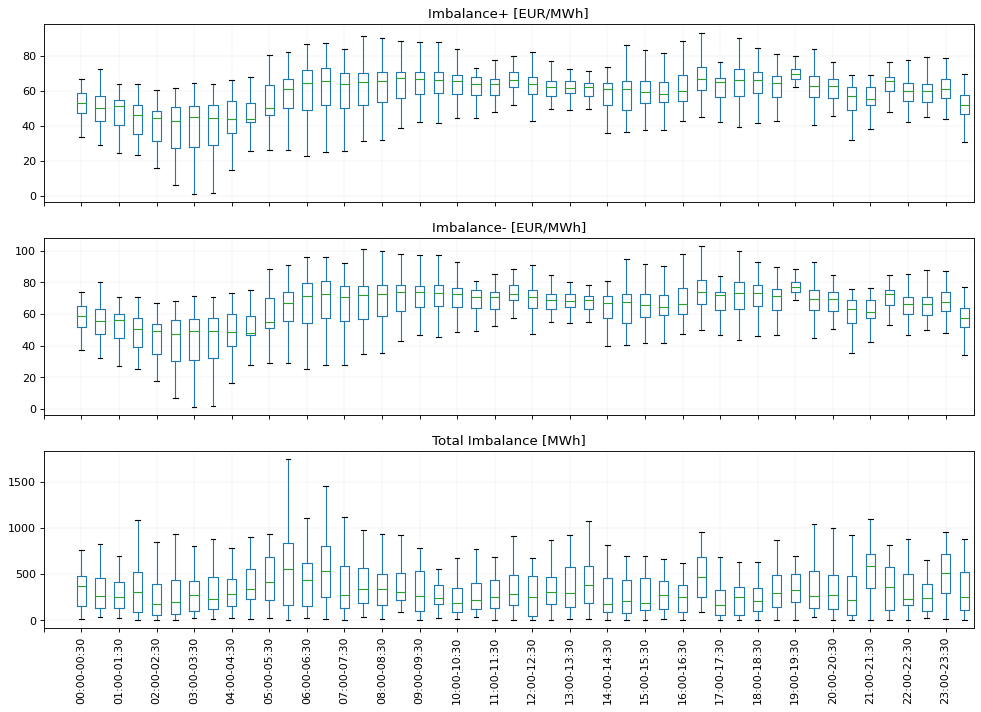

In [12]:
startt_month = f'{year}-01-01'
endd_month = f'{year}-01-31 23:30'
per_30mn_month = pd.date_range(startt_month, endd_month, freq='30T',)# Create date range to hold hour data
per_1day_month = pd.date_range(startt_month, endd_month, freq='D',)  # Create date range to hold hour data

hour_imb_pos_list, hour_imb_neg_list ,hour_imb_tot_list = [], [], []
imbalance_data_month = imbalance_data[imbalance_data.index.month_name() == 'January']
total_days = len(imbalance_data_month.index)//48

for day_number in range(0,total_days-1):
    indexing = (per_1day_month[day_number]<= imbalance_data_month.index) & (imbalance_data_month.index < per_1day_month[day_number+1])
        
    hour_imb_pos_list.append(imbalance_data_month[indexing]['Imbalance+ [EUR/MWh]'].values) 
    hour_imb_neg_list.append(imbalance_data_month[indexing]['Imbalance- [EUR/MWh]'].values)  
    hour_imb_tot_list.append(imbalance_data_month[indexing]['Total Imbalance [MWh]'].values) 
    
hour_imb_pos=pd.DataFrame(data=hour_imb_pos_list, index = range(0, total_days-1))
hour_imb_neg=pd.DataFrame(data=hour_imb_neg_list, index = range(0, total_days-1))
hour_imb_tot=pd.DataFrame(data=hour_imb_tot_list, index = range(0, total_days-1))
    
# Plotting   
fig, axx = plt.subplots(3,1, figsize=(15,10),sharex=True,dpi=80)
hour_imb_pos.boxplot(ax=axx[0],sym='')
hour_imb_neg.boxplot(ax=axx[1],sym='')
hour_imb_tot.boxplot(ax=axx[2],sym='')
axx[0].set(xticks = range(-1,48,2), xticklabels=Hour_str);
axx[1].set(xticks = range(-1,48,2),);
axx[2].set(xticks = range(-1,48,2),);

for j in range(0,3): 
    axx[j].set(title=title_list[j],)
    axx[j].grid(True,lw=0.1)
    
plt.xticks(rotation=90,);

## Particular Day in week of month data
Monday and Friday on January

In [13]:
curr_day = [0, 4]  # Day indice are in such as 0 => Monday, 1=> Tuesday .... , 6 =>Sunday

# describe a simple function 
def extract_daily_data(index_day):
    day_imb_pos = imbalance_data_month[imbalance_data_month.index.day_of_week == index_day]['Imbalance+ [EUR/MWh]'].values
    day_imb_neg = imbalance_data_month[imbalance_data_month.index.day_of_week == index_day]['Imbalance- [EUR/MWh]'].values
    day_imb_tot = imbalance_data_month[imbalance_data_month.index.day_of_week == index_day]['Total Imbalance [MWh]'].values
    day_imb_pos_df = pd.DataFrame(np.reshape(day_imb_pos, (-1,48)),columns=range(0,48))
    day_imb_neg_df = pd.DataFrame(np.reshape(day_imb_neg, (-1,48)),columns=range(0,48))
    day_imb_tot_df = pd.DataFrame(np.reshape(day_imb_tot, (-1,48)),columns=range(0,48))
    
    return day_imb_pos_df, day_imb_neg_df, day_imb_tot_df

# Call function 
day1_imb_df = extract_daily_data(curr_day[0])
day2_imb_df = extract_daily_data(curr_day[1])

#### Plot

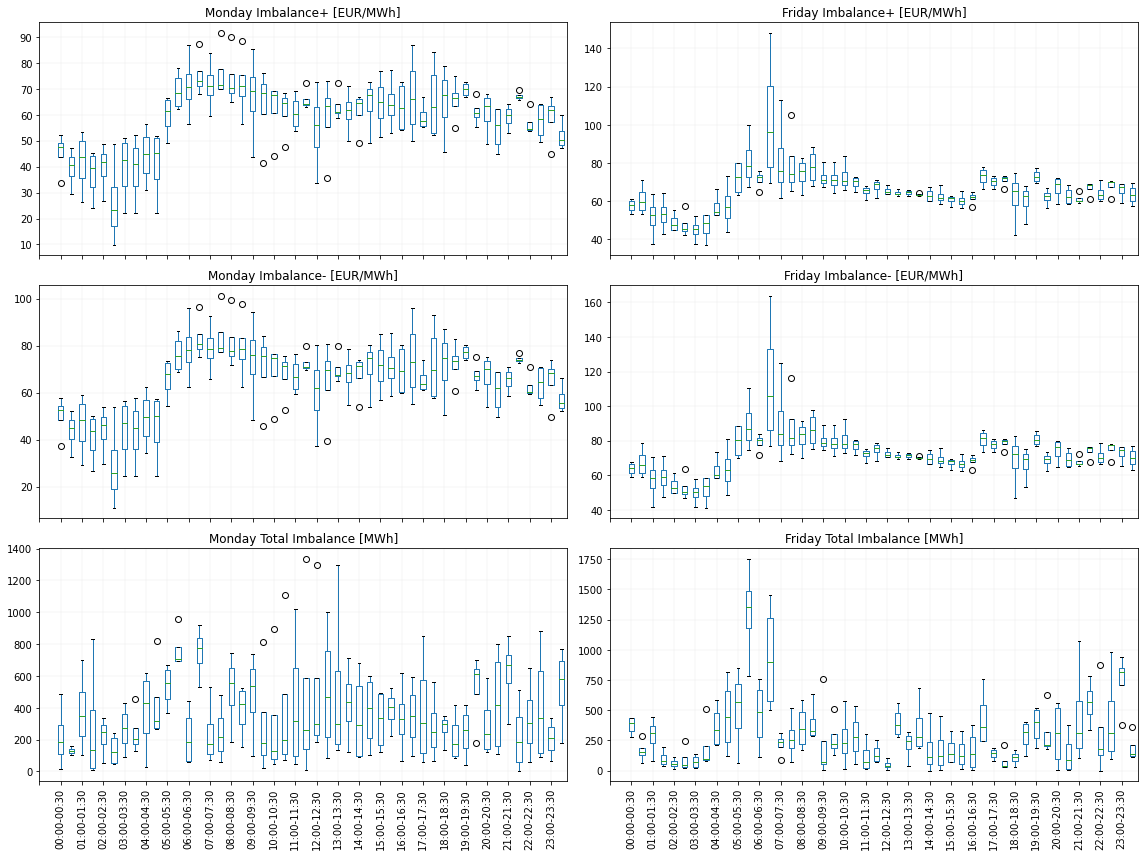

In [14]:
nrows, ncols = 3, 2 # define number of rows and columns
fig, axx = plt.subplots(nrows, ncols, figsize=(16,12),sharex=True)

for cur_row in range(0, nrows):   
    day1_imb_df[cur_row].boxplot(ax=axx[cur_row,0])
    day2_imb_df[cur_row].boxplot(ax=axx[cur_row,1])
    
axx[2,0].set(xticks = range(-1,48,2), xticklabels=Hour_str);
axx[2,1].set(xticks = range(-1,48,2), xticklabels=Hour_str);

dayys = [week_days[curr_day[0]],week_days[curr_day[1]]] # Extract name of the selected days

for cur_row in range(0,nrows): 
    for cur_col in range(0,ncols):
        axx[cur_row,cur_col].set(title=f'{dayys[cur_col]} {title_list[cur_row]}')
        axx[cur_row,cur_col].grid(True,lw=0.1)

axx[2,0].tick_params(axis='x', labelrotation = 90)
axx[2,1].tick_params(axis='x', labelrotation = 90)

fig.tight_layout()

___
***

# 2020 Data

## Extract DataSet

In [15]:
year = '2020'
file_name = folder+'Imbalance_'+year+'.csv'

startt = year+'-01-01'      # First index
endd = year+'-12-31 23:30'  # last index

per_30mn = pd.date_range(startt, endd, freq='30T',)     # Create a date range at a freq of 30mn 
per_1day = pd.date_range(startt, endd, freq='D',)       # Create a date range at a freq of 1 day 

per_1month =  pd.date_range(startt, endd, freq='M',)    # Create date range to

imbalance_data = pd.read_csv(file_name,index_col='ISP (UTC)')
imbalance_data.index = per_30mn

## Basic statistic on the dataset

In [16]:
imbalance_data.describe()

,Imbalance+ [EUR/MWh],Imbalance- [EUR/MWh],Total Imbalance [MWh]
count,17568.000000,17568.000000,17565.000000
mean,31.301322,34.743383,380.343638
std,27.581095,29.625107,313.641914
min,-541.740000,-490.140000,0.000000
25%,18.277500,20.197500,145.000000
50%,29.700000,32.820000,307.000000
75%,41.670000,46.050000,535.000000
max,950.950000,1051.050000,2669.000000


## Extract Month Data
Each month consists of 48*nb_days data points

In [17]:
month_imb_pos, month_imb_neg ,month_imb_tot = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

for elm in per_1month.month_name():
    
    var_int = imbalance_data[per_30mn.month_name() == elm]['Imbalance+ [EUR/MWh]'].values # Positive imbalance (Selling) 
    nan_to_add = np.nan*np.zeros((1488-len(var_int))) # add NaN so that the data across all the months has the same 
                                                      # maximal length of 1488 = 31*48 (31 Days and 48 period of 30mn)
    month_imb_pos[elm] = np.concatenate((var_int,nan_to_add))
    
    var_int = imbalance_data[per_30mn.month_name() == elm]['Imbalance- [EUR/MWh]'].values # Negative imbalance (buying)
    month_imb_neg[elm] = np.concatenate((var_int,nan_to_add))
     
    var_int = imbalance_data[per_30mn.month_name() == elm]['Total Imbalance [MWh]'].values # Total imbalance
    month_imb_tot[elm] = np.concatenate((var_int,nan_to_add))

####  Plot data

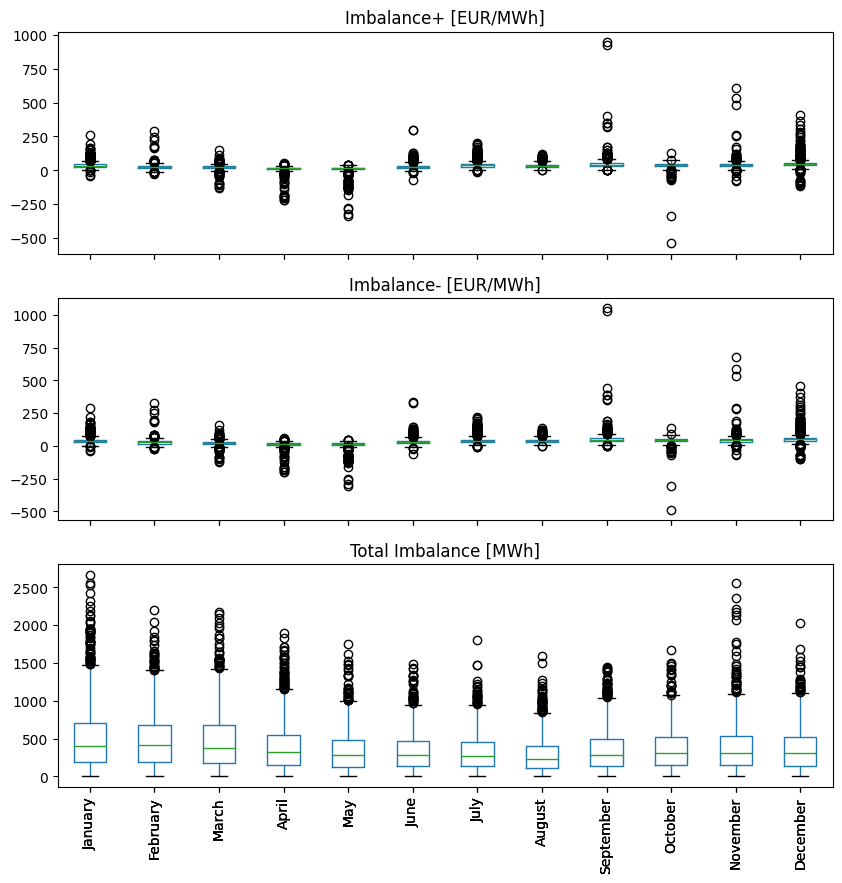

In [18]:
# Plotting 
fig, axx = plt.subplots(3,1, figsize=(10,10),sharex=True, dpi=100)
al = month_imb_pos.boxplot(ax=axx[0],)
month_imb_neg.boxplot(ax=axx[1],)
month_imb_tot.boxplot(ax=axx[2],);

for j in range(0,3): 
    axx[j].set(title=title_list[j],)
    axx[j].grid(False)
    
plt.xticks(rotation=90);

## Extract daily mean over each month

Here we consider the daily mean of the imbalance price data. A monthly aggregation is produced hereafter. Every month, therefore, consists of 28 (February), 30 or 31 data points.

In [19]:
# Create Dataframe to store the data 
month_imb_pos, month_imb_neg ,month_imb_tot = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

cur_nb_days = 1 # Index of the current day

for elm in per_1month.month_name():
    
    imb_pos_list, imb_neg_list ,imb_tot_list = [], [], [] # List to store data
    
    tot_day_month = per_30mn[per_30mn.month_name() == elm].days_in_month[1] # Extract the total number of days in the considered month
    
    for jour in range(cur_nb_days, cur_nb_days+tot_day_month): # For each day in the month compute mean and store it
        imb_pos,imb_neg,imb_tot = imbalance_data[per_30mn.dayofyear == jour].mean()
        imb_pos_list.append(imb_pos), 
        imb_neg_list.append(imb_neg),
        imb_tot_list.append(imb_tot)
    
    nan_to_add = np.nan*np.zeros((31-len(imb_pos_list))) # 31 upper bound of number of days in a month
    month_imb_pos[elm] = np.concatenate((np.array(imb_pos_list),nan_to_add)) # Positive imbalance (Selling)  
    month_imb_neg[elm] = np.concatenate((np.array(imb_neg_list),nan_to_add)) # Negative imbalance (buying)
    month_imb_tot[elm] = np.concatenate((np.array(imb_tot_list),nan_to_add)) # total imbalance
    
    cur_nb_days = cur_nb_days + tot_day_month

####  Plot data

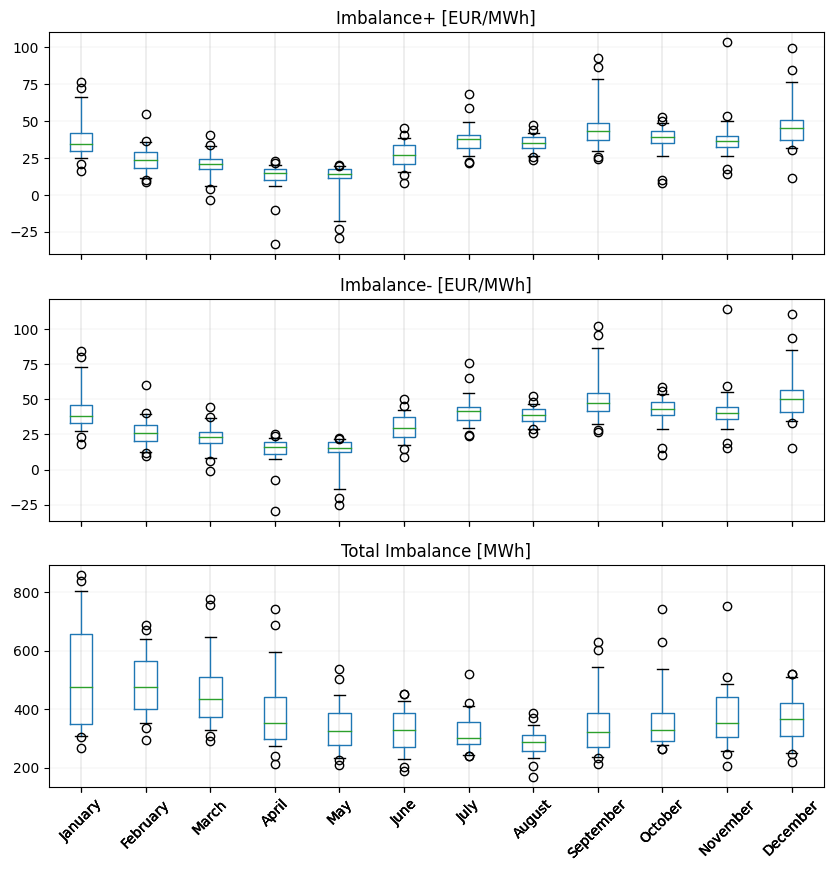

In [20]:
# Ploting 
fig, axx = plt.subplots(3,1, figsize=(10,10),sharex=True,dpi=100)

# rer1 = month_imb_pos.boxplot(ax=axx[0],whis=[5,95],widths=0.25, patch_artist=True,)
month_imb_pos.boxplot(ax=axx[0],whis=[5,95],widths=0.35,)
month_imb_neg.boxplot(ax=axx[1],whis=[5,95],widths=0.35)
month_imb_tot.boxplot(ax=axx[2],whis=[5,95],widths=0.35);


for j in range(0,3): 
    axx[j].set(title=title_list[j],)
    axx[j].grid(True,lw=0.1)
plt.xticks(rotation=45);

## Extract Weekdays data
Whole year data, each day consists of 48*52 data points

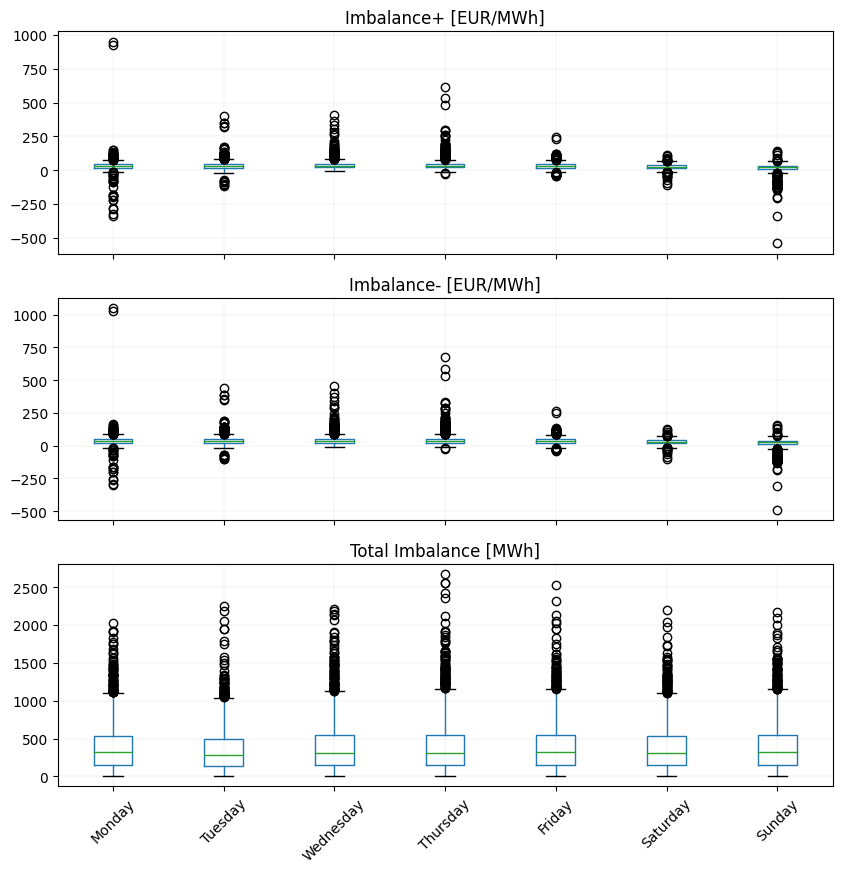

In [21]:
weekday_imb_pos, weekday_imb_neg ,weekday_imb_tot = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

max_length = 0
for day_number in range(1,8): # Extract the day with the highest frequency during the year
    max_length = np.maximum(max_length,len(imbalance_data[per_30mn.isocalendar()['day']==day_number]) )
    

for elm in range(1,8):
#     Positive imbalance (Selling)
    var_int = imbalance_data[per_30mn.isocalendar()['day']==elm]['Imbalance+ [EUR/MWh]'].values # Positive imbalance (Selling)
    nan_to_add = np.nan*np.zeros((max_length-len(var_int)))
    weekday_imb_pos[elm] = np.concatenate((var_int,nan_to_add))
    
    var_int = imbalance_data[per_30mn.isocalendar()['day']==elm]['Imbalance- [EUR/MWh]'].values # Negative imbalance (buying)
    weekday_imb_neg[elm] = np.concatenate((var_int,nan_to_add))
    
    var_int = imbalance_data[per_30mn.isocalendar()['day']==elm]['Total Imbalance [MWh]'].values # total imbalance
    weekday_imb_tot[elm] = np.concatenate((var_int,nan_to_add))
    
    
# Plotting 
fig, axx = plt.subplots(3,1, figsize=(10,10),sharex=True,dpi=100)

weekday_imb_pos.boxplot(ax=axx[0],widths=0.35,)
weekday_imb_neg.boxplot(ax=axx[1],widths=0.35)
weekday_imb_tot.boxplot(ax=axx[2],widths=0.35);

for j in range(0,3): 
    axx[j].set(title=title_list[j],)
    axx[j].grid(True,lw=0.1)
plt.xticks(ticks= range(1,8), labels=week_days, rotation=45);

## Extract particular months, using March and August as example
Each day consists of 48*nb_days(month) data points

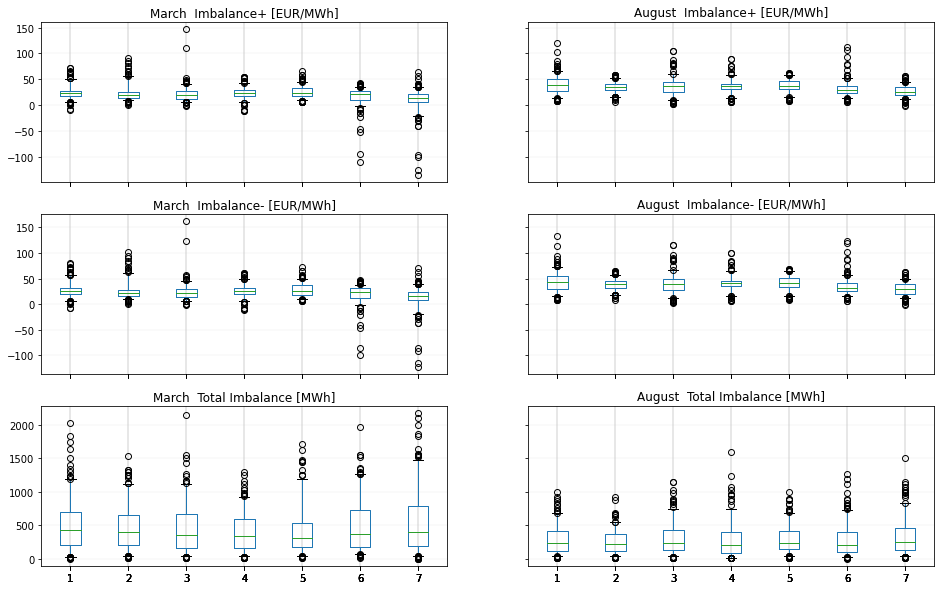

In [22]:
# Define a simple function        
def extract_month_data (month_name, first_day, last_day ):

    per_30mn_month = pd.date_range(first_day, last_day, freq='30T',)
    per_1day_month = pd.date_range(first_day, last_day, freq='D',)

    imbalance_data_month = imbalance_data[imbalance_data.index.month_name() == month_name]
    weekday_imb_pos, weekday_imb_neg ,weekday_imb_tot = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

    max_length = 0
    for day_number in range(1,8):
        max_length = np.maximum(max_length,len(imbalance_data_month[per_30mn_month.isocalendar()['day']==day_number]) )

    for elm in range(1,8):

        var_int = imbalance_data_month[per_30mn_month.isocalendar()['day']==elm]['Imbalance+ [EUR/MWh]'].values # Negative imbalance (Selling)
        nan_to_add = np.nan*np.zeros((max_length-len(var_int)))
        weekday_imb_pos[elm] = np.concatenate((var_int,nan_to_add))

        var_int = imbalance_data_month[per_30mn_month.isocalendar()['day']==elm]['Imbalance- [EUR/MWh]'].values # Negative imbalance (buying)
        weekday_imb_neg[elm] = np.concatenate((var_int,nan_to_add))

        var_int = imbalance_data_month[per_30mn_month.isocalendar()['day']==elm]['Total Imbalance [MWh]'].values # Total imbalance 
        nan_to_add = np.nan*np.zeros((max_length-len(var_int)))
        weekday_imb_tot[elm] = np.concatenate((var_int,nan_to_add))
        
    return weekday_imb_pos, weekday_imb_neg, weekday_imb_tot

# Use the created function------------------------------------------------------------------------------------------------------------------
month_name = ['March', 'August' ]  # Define name of selected months

startt_month = f'{year}-03-01'
endd_month = f'{year}-03-31 23:30' # IMPORTANT: Make sure the number and the last day of the selected month complies with reality
                                   # Eg: 01 for January which last day is 31 | 06 for June which last day is 30
startt_month2 = f'{year}-08-01'
endd_month2 = f'{year}-08-31 23:30'

# call function 
month0 = extract_month_data(month_name[0],startt_month, endd_month )
month1 = extract_month_data(month_name[1],startt_month2, endd_month2 )

# Ploting output of the function
fig, axx = plt.subplots(3,2, figsize=(16,10),sharex=True,sharey='row')

# rer1 = month_imb_pos.boxplot(ax=axx[0],whis=[5,95],widths=0.25, patch_artist=True,)
for elm in range(0, 3 ): 
    month0[elm].boxplot(ax=axx[elm,0],whis=[5,95],widths=0.35,)
    month1[elm].boxplot(ax=axx[elm,1],whis=[5,95],widths=0.35,)


for rows in range(0,3): 
    for colls in range(0,2):
        titre = month_name[colls] + '  ' + title_list[rows] 
        axx[rows, colls].set(title=titre,)
        axx[rows, colls].grid(True,lw=0.1)
# plt.xticks(ticks= range(1,8), labels=week_days, rotation=45);



##  Hour of day
Whole year data, each hour consists of 365 data points

In [23]:
hour_imb_pos_list, hour_imb_neg_list ,hour_imb_tot_list = [], [], [], 
total_days = len(per_1day) # Get the total numbers of day in the year 

for day_number in range(0,total_days-1):
    indexing = (per_1day[day_number]<= imbalance_data.index) & (imbalance_data.index < per_1day[day_number+1])

    hour_imb_pos_list.append( imbalance_data[indexing]['Imbalance+ [EUR/MWh]'].values )
    hour_imb_neg_list.append(imbalance_data[indexing]['Imbalance- [EUR/MWh]'].values)
    hour_imb_tot_list.append(imbalance_data[indexing]['Total Imbalance [MWh]'].values) 
    
    
hour_imb_pos = pd.DataFrame(data=hour_imb_pos_list, index=range(0,total_days-1))
hour_imb_neg = pd.DataFrame(data=hour_imb_neg_list, index=range(0,total_days-1))
hour_imb_tot = pd.DataFrame(data=hour_imb_tot_list, index=range(0,total_days-1))

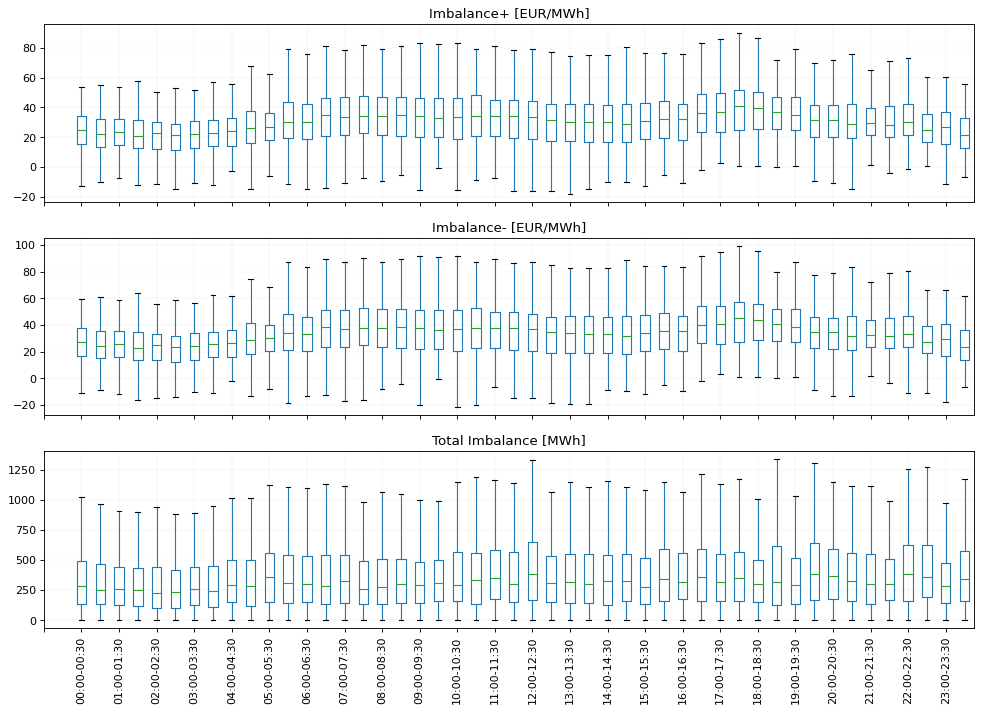

In [24]:
fig, axx = plt.subplots(3,1, figsize=(15,10),sharex=True,dpi=80)
hour_imb_pos.boxplot(ax=axx[0],sym='')
hour_imb_neg.boxplot(ax=axx[1],sym='')
hour_imb_tot.boxplot(ax=axx[2],sym='')
axx[0].set(xticks = range(-1,48,2), xticklabels=Hour_str);
axx[1].set(xticks = range(-1,48,2),);
axx[2].set(xticks = range(-1,48,2),);

for j in range(0,3): 
    axx[j].set(title=title_list[j],)
    axx[j].grid(True,lw=0.1)
plt.xticks(rotation=90,);

## July data
Each hour consists of 31 data points

In [25]:
startt_month = f'{year}-07-01'
endd_month = f'{year}-07-31 23:30'
per_30mn_month = pd.date_range(startt_month, endd_month, freq='30T',)# Create date range to hold hour data
per_1day_month = pd.date_range(startt_month, endd_month, freq='D',)  # Create date range to hold hour data

hour_imb_pos_list, hour_imb_neg_list ,hour_imb_tot_list = [], [], []
imbalance_data_month = imbalance_data[imbalance_data.index.month_name() == 'July']
total_days = len(imbalance_data_month.index)//48

for day_number in range(0,total_days-1):
    indexing = (per_1day_month[day_number]<= imbalance_data_month.index) & (imbalance_data_month.index < per_1day_month[day_number+1])
        
    hour_imb_pos_list.append(imbalance_data_month[indexing]['Imbalance+ [EUR/MWh]'].values) 
    hour_imb_neg_list.append(imbalance_data_month[indexing]['Imbalance- [EUR/MWh]'].values)  
    hour_imb_tot_list.append(imbalance_data_month[indexing]['Total Imbalance [MWh]'].values) 
    
hour_imb_pos=pd.DataFrame(data=hour_imb_pos_list, index = range(0, total_days-1))
hour_imb_neg=pd.DataFrame(data=hour_imb_neg_list, index = range(0, total_days-1))
hour_imb_tot=pd.DataFrame(data=hour_imb_tot_list, index = range(0, total_days-1))

#### Plot

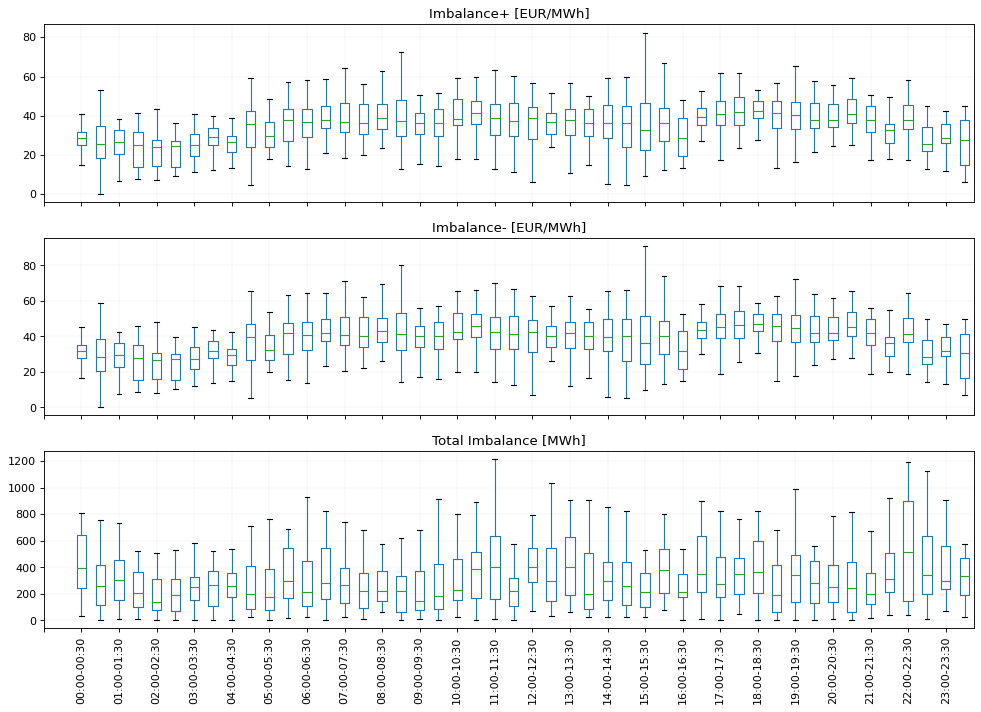

In [26]:
fig, axx = plt.subplots(3,1, figsize=(15,10),sharex=True,dpi=80)
hour_imb_pos.boxplot(ax=axx[0],sym='')
hour_imb_neg.boxplot(ax=axx[1],sym='')
hour_imb_tot.boxplot(ax=axx[2],sym='')
axx[0].set(xticks = range(-1,48,2), xticklabels=Hour_str);
axx[1].set(xticks = range(-1,48,2),);
axx[2].set(xticks = range(-1,48,2),);

for j in range(0,3): 
    axx[j].set(title=title_list[j],)
    axx[j].grid(True,lw=0.1)
    
plt.xticks(rotation=90,);

## Particular Day in week of month data
Monday and Sunday on July

In [27]:
curr_day = [0, 6]  # Day indice are in such as 0 => Monday, 1=> Tuesday .... , 6 =>Sunday

# describe a simple function 
def extract_daily_data(index_day):
    day_imb_pos = imbalance_data_month[imbalance_data_month.index.day_of_week == index_day]['Imbalance+ [EUR/MWh]'].values
    day_imb_neg = imbalance_data_month[imbalance_data_month.index.day_of_week == index_day]['Imbalance- [EUR/MWh]'].values
    day_imb_tot = imbalance_data_month[imbalance_data_month.index.day_of_week == index_day]['Total Imbalance [MWh]'].values
    day_imb_pos_df = pd.DataFrame(np.reshape(day_imb_pos, (-1,48)),columns=range(0,48))
    day_imb_neg_df = pd.DataFrame(np.reshape(day_imb_neg, (-1,48)),columns=range(0,48))
    day_imb_tot_df = pd.DataFrame(np.reshape(day_imb_tot, (-1,48)),columns=range(0,48))
    
    return day_imb_pos_df, day_imb_neg_df, day_imb_tot_df

# Call function 
day1_imb_df = extract_daily_data(curr_day[0])
day2_imb_df = extract_daily_data(curr_day[1])

#### Plot

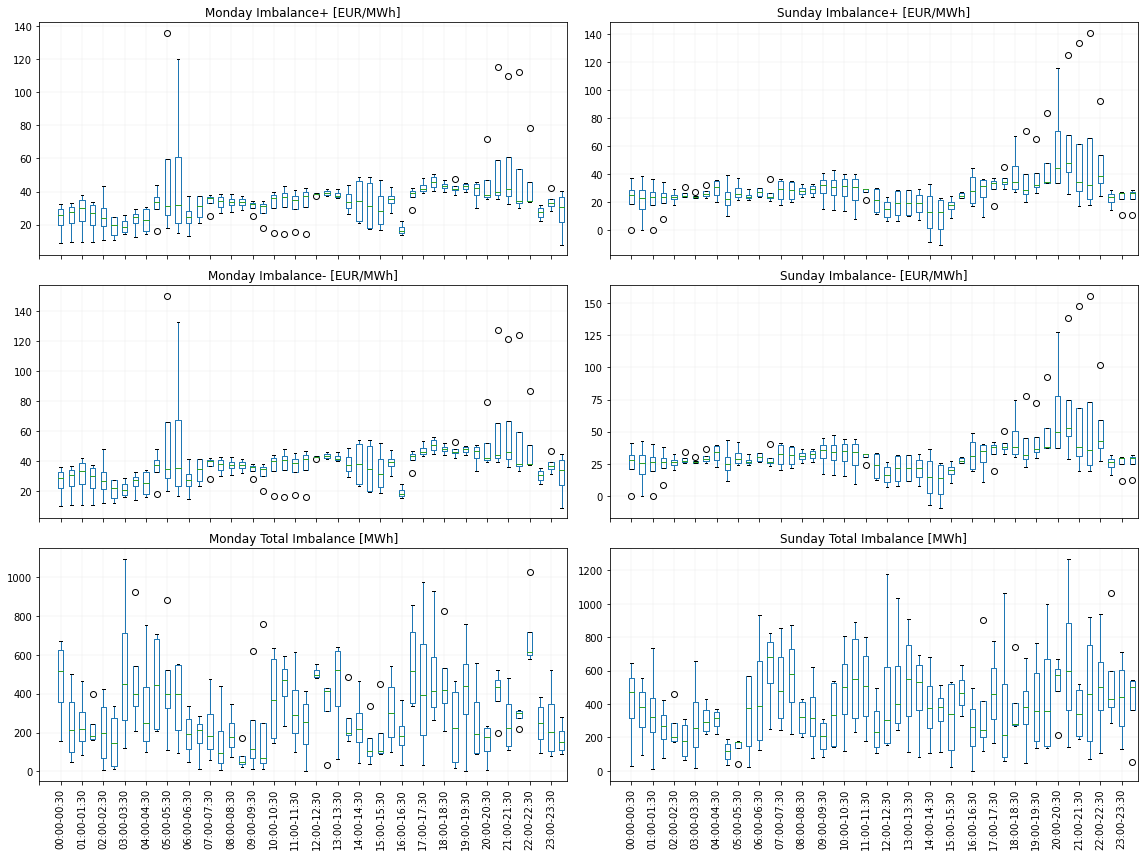

In [28]:
nrows, ncols = 3, 2 # define number of rows and columns
fig, axx = plt.subplots(nrows, ncols, figsize=(16,12),sharex=True)

for cur_row in range(0, nrows):   
    day1_imb_df[cur_row].boxplot(ax=axx[cur_row,0])
    day2_imb_df[cur_row].boxplot(ax=axx[cur_row,1])
    
axx[2,0].set(xticks = range(-1,48,2), xticklabels=Hour_str);
axx[2,1].set(xticks = range(-1,48,2), xticklabels=Hour_str);

dayys = [week_days[curr_day[0]],week_days[curr_day[1]]] # Extract name of the selected days

for cur_row in range(0,nrows): 
    for cur_col in range(0,ncols):
        axx[cur_row,cur_col].set(title=f'{dayys[cur_col]} {title_list[cur_row]}')
        axx[cur_row,cur_col].grid(True,lw=0.1)

axx[2,0].tick_params(axis='x', labelrotation = 90)
axx[2,1].tick_params(axis='x', labelrotation = 90)

fig.tight_layout()